<a href="https://colab.research.google.com/github/shilpasy/Variant-Prioritization-miniproject-with-AlphaMissense-cBioPortal-and-ESM-models/blob/main/4_UMAPs_dist_logit_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==== TP53 ESM2 embeddings: UMAP + cosine-to-WT + plots ====

# If needed:
# !pip install umap-learn scikit-learn fair-esm

import torch, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances
#import esm
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances


In [ ]:
from google.colab import drive
import pandas as pd
import gzip
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EMB_PATH = "/content/drive/MyDrive/AlphaMissense_ex/TP53_ESM2_embeddings.csv"  # produced earlier in ESM_StructuralFeatureAugmentation.ipynb
MERGED_PATH = "/content/drive/MyDrive/AlphaMissense_ex/TP53_cbioportal_mutations_annotated_with_AlphaMissense.csv"  # merged mutations file from cbiortal notebook
OUT_CSV = "/content/drive/MyDrive/AlphaMissense_ex/TP53_ESM2_umap_augmented.csv"

# -----------------------
# Load embeddings created in the ESMs notebooks
# -----------------------
emb = pd.read_csv(EMB_PATH)
# feature columns = all numeric except Variant
feat_cols = [c for c in emb.columns if c != "Variant" and np.issubdtype(emb[c].dtype, np.number)]
X = emb[feat_cols].values

# L2-normalize before cosine distance
Xn = normalize(X, norm="l2")

# find WT row (by label), else fallback to first row
if (emb["Variant"] == "WT").any():
    wt_idx = emb.index[emb["Variant"] == "WT"][0]
else:
    wt_idx = 0
wt_vec = Xn[[wt_idx]]

# cosine distance to WT
cos_to_wt = cosine_distances(Xn, wt_vec).ravel()
emb["cosine_to_WT"] = cos_to_wt
# -----------------------
# UMAP to 2D
# -----------------------
reducer = umap.UMAP(n_neighbors=12, min_dist=0.1, metric="euclidean", random_state=42)
umap_2d = reducer.fit_transform(Xn)
emb["UMAP1"] = umap_2d[:, 0]
emb["UMAP2"] = umap_2d[:, 1]

ann = pd.read_csv(MERGED_PATH)

def normv(v):
    if isinstance(v, str):
        return v if v.startswith("p.") else f"p.{v}"
    return v

emb["Variant_norm"] = emb["Variant"].apply(normv)
ann["Variant_norm"] = ann["Variant"].apply(normv)

cols_keep = ["Variant_norm","AlphaMissense_Pathogenicity","AlphaMissense_Class",
             "Position","WT_AA","Mut_AA","proteinChange"]
emb_aug = emb.merge(ann[cols_keep].drop_duplicates("Variant_norm"),
                    on="Variant_norm", how="left")

# +++++++++++++++++++++++
# compute site-specific (change (del) logit) at mutated residue with ESM-2
# ++++++++++++++++++++++++
# small model for speed; switch to esm2_t6_8M_UR50D() if you no gpu avail
device = "cuda" if torch.cuda.is_available() else "cpu"
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model = model.to(device).eval()
batch_converter = alphabet.get_batch_converter()

# Canonical TP53 sequence (UniProt P04637)
tp53_seq = (
    "MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGP"
    "DEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKS"
    "VSTSGEYRHVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIIITLEDSSGNLLG"
    "LPCVYIWGDYLPQEEQELREVAPRCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVV"
    "PYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIIITLEDSSGNLLGLPCVYIWGDYLP"
    "QEEQELREVAP"
)

def parse_variant(v):
    m = re.match(r"p\.([A-Z])(\d+)([A-Z])$", str(v))
    if not m:
        return None
    wt, pos, mt = m.groups()
    return wt, int(pos), mt

def delta_logit_at_site(variant: str):
    parsed = parse_variant(variant)
    if not parsed:
        return np.nan
    wt, pos, mt = parsed
    if pos < 1 or pos > len(tp53_seq):
        return np.nan
    # sanity: check WT AA matches canonical
    if tp53_seq[pos-1] != wt:
        return np.nan
    mut_seq = tp53_seq[:pos-1] + mt + tp53_seq[pos:]

    # batch WT and MUT together so index aligns (position offset +1)
    data = [("WT", tp53_seq), (variant, mut_seq)]
    labels, strs, toks = batch_converter(data)
    toks = toks.to(device)
    with torch.no_grad():
        out = model(toks, return_contacts=False)
        logits = out["logits"]  # [batch, L, vocab]
    i = pos  # ESM has [CLS] at 0 → position i corresponds to seq pos
    wt_idx = alphabet.get_idx(wt)
    mt_idx = alphabet.get_idx(mt)
    return float(logits[1, i, mt_idx].item() - logits[0, i, wt_idx].item())

emb_aug["delta_logit_site"] = np.nan
mask_vars = emb_aug["Variant"].ne("WT") & emb_aug["Variant"].str.startswith("p.", na=False)
for i, v in emb_aug.loc[mask_vars, "Variant"].items():
    emb_aug.at[i, "delta_logit_site"] = delta_logit_at_site(v)

emb_aug.to_csv(OUT_CSV, index=False)
print(f"saved augmented table: {OUT_CSV}")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


NameError: name 'esm' is not defined

In [ ]:
emb_aug = pd.read_csv(OUT_CSV)

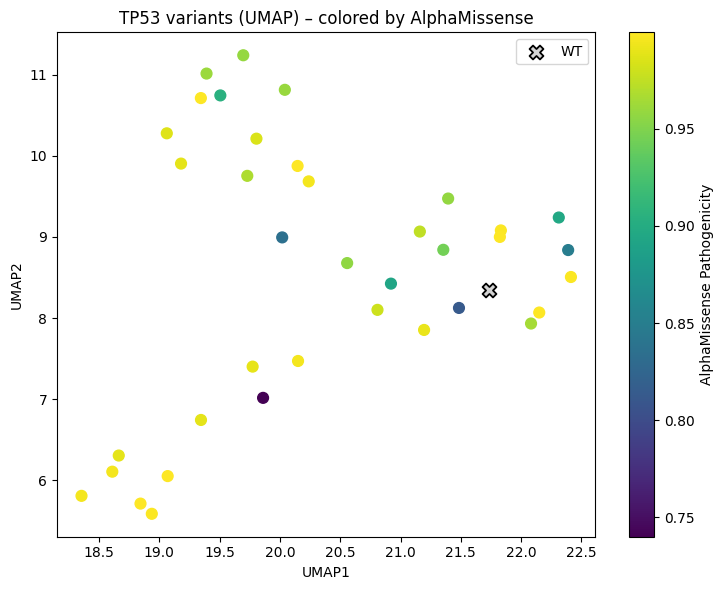

saved: /content/drive/MyDrive/AlphaMissense_ex/TP53_UMAP_color_by_AlphaMissense.png


In [ ]:
PLOT1 = "/content/drive/MyDrive/AlphaMissense_ex/TP53_UMAP_color_by_AlphaMissense.png"

# -----------------------
# Plot 1: color by AlphaMissense (variants only), WT shown neutral
# -----------------------
vt = emb_aug[emb_aug["Variant"]!="WT"].copy()
wt = emb_aug[emb_aug["Variant"]=="WT"]
vt_am = vt.dropna(subset=["AlphaMissense_Pathogenicity"])

plt.figure(figsize=(7.5,6))
sc = plt.scatter(vt_am["UMAP1"], vt_am["UMAP2"],
                 c=vt_am["AlphaMissense_Pathogenicity"], s=60, cmap="viridis")
plt.colorbar(sc, label="AlphaMissense Pathogenicity")
if not wt.empty:
    plt.scatter(wt["UMAP1"], wt["UMAP2"], s=100, marker="X",
                edgecolor="black", facecolor="lightgray", linewidth=1.3, label="WT")
plt.legend()
plt.title("TP53 variants (UMAP) – colored by AlphaMissense")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2"); plt.tight_layout()
plt.savefig(PLOT1, dpi=150); plt.show()
print(f"saved: {PLOT1}")

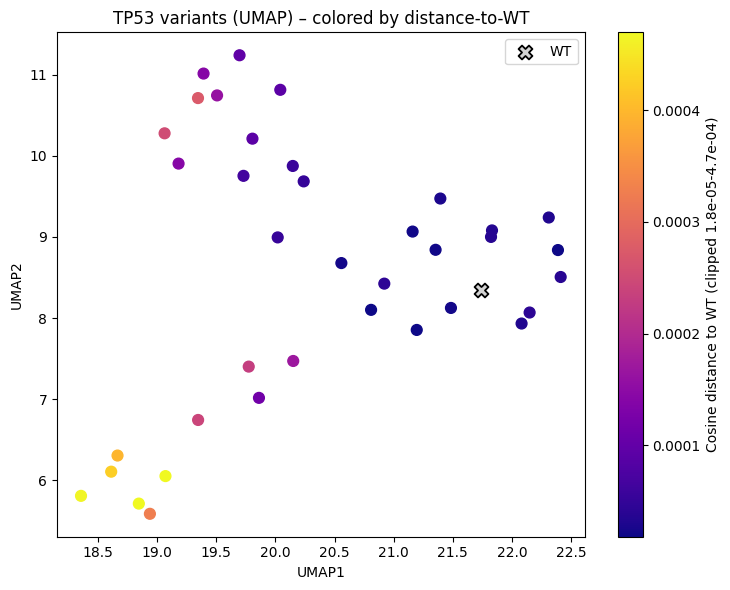

Saved: /content/drive/MyDrive/AlphaMissense_ex/TP53_UMAP_color_by_cosine_to_WT.png


In [ ]:
PLOT2 = "/content/drive/MyDrive/AlphaMissense_ex/TP53_UMAP_color_by_cosine_to_WT.png"

# -----------------------
# Plot 2: color by cosine distance to WT (quantile-clipped), WT neutral
# -----------------------
qmin, qmax = np.quantile(vt["cosine_to_WT"].dropna(), [0.05, 0.95])
vals = vt["cosine_to_WT"].clip(qmin, qmax)

plt.figure(figsize=(7.5,6))
sc2 = plt.scatter(vt["UMAP1"], vt["UMAP2"], c=vals, s=60, cmap="plasma")
plt.colorbar(sc2, label=f"Cosine distance to WT (clipped {qmin:.1e}-{qmax:.1e})")
if not wt.empty:
    plt.scatter(wt["UMAP1"], wt["UMAP2"], s=100, marker="X",
                edgecolor="black", facecolor="lightgray", linewidth=1.3, label="WT")
plt.legend()
plt.title("TP53 variants (UMAP) – colored by distance-to-WT")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2"); plt.tight_layout()
plt.savefig(PLOT2, dpi=150); plt.show()
print(f"Saved: {PLOT2}")

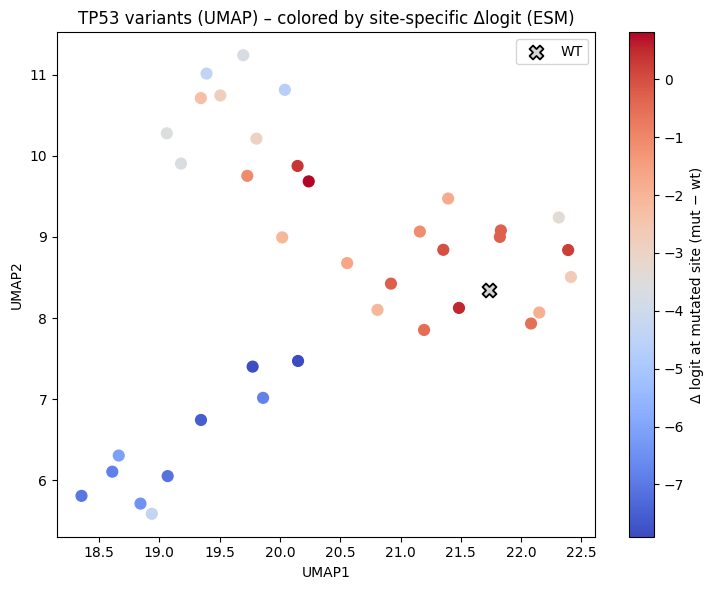

Saved: /content/drive/MyDrive/AlphaMissense_ex/TP53_UMAP_color_by_delta_logit.png


In [ ]:
PLOT3 = "/content/drive/MyDrive/AlphaMissense_ex/TP53_UMAP_color_by_delta_logit.png"

# -----------------------
# Plot 3: color by site-specific delta logit (ESM), WT neutral
# -----------------------
vt_dl = vt.dropna(subset=["delta_logprob_masked"])
plt.figure(figsize=(7.5,6))
sc3 = plt.scatter(vt_dl["UMAP1"], vt_dl["UMAP2"], c=vt_dl["delta_logprob_masked"],
                  s=60, cmap="coolwarm")
plt.colorbar(sc3, label="Δ logit at mutated site (mut − wt)")
if not wt.empty:
    plt.scatter(wt["UMAP1"], wt["UMAP2"], s=100, marker="X",
                edgecolor="black", facecolor="lightgray", linewidth=1.3, label="WT")
plt.legend()
plt.title("TP53 variants (UMAP) – colored by site-specific Δlogit (ESM)")
plt.xlabel("UMAP1"); plt.ylabel("UMAP2"); plt.tight_layout()
plt.savefig(PLOT3, dpi=150); plt.show()
print(f"Saved: {PLOT3}")

In [ ]:
# quick table: top variants by |del logit|
top = vt_dl.reindex(vt_dl["delta_logit_site"].abs().sort_values(ascending=False).index) \
           [["Variant","Position","AlphaMissense_Pathogenicity","AlphaMissense_Class","cosine_to_WT","delta_logit_site"]] \
           .head(10)
print("\nTop |delta logit| variants (site-specific ESM effect):")
print(top.to_string(index=False))


Top |delta logit| variants (site-specific ESM effect):
Variant  Position  AlphaMissense_Pathogenicity AlphaMissense_Class  cosine_to_WT  delta_logit_site
p.T256R     256.0                       0.9902          pathogenic      0.000231         -6.761618
p.V203L     203.0                       0.7401          pathogenic      0.000116         -6.706997
p.T256P     256.0                       0.9887          pathogenic      0.000242         -6.060222
p.T256K     256.0                       0.9946          pathogenic      0.000169         -6.056259
p.R273L     273.0                       0.9954          pathogenic      0.000465         -5.727146
p.R273S     273.0                       0.9993          pathogenic      0.000489         -5.658760
p.R273C     273.0                       0.9945          pathogenic      0.000425         -5.598317
p.R273P     273.0                       0.9988          pathogenic      0.000502         -5.039467
p.L111Q     111.0                       0.9593       

TP53 Variant Interpretation with AlphaMissense + ESM-2 :

In this analysis, I combined genomic annotations (AlphaMissense) with protein language model embeddings (ESM-2) to study pathogenic missense variants in TP53, a central tumor suppressor gene.

Dimensionality reduction (UMAP) cleanly separated variants into clusters, while the wild-type TP53 (WT) served as a neutral reference point. Pathogenicity scores from AlphaMissense showed consistent enrichment of high-impact variants across the embedding space.

When examining cosine distance to WT embeddings, most variants remained close to WT (expected since only one residue is changed), but a subset of mutations -  including several well-known hotspots — drifted farther away, hinting at stronger perturbations to protein representation.

To get a more site-specific signal, I used ESM logits at the mutated residue. This highlighted biologically important hotspots: variants at codon 273 (R273H, R273C, R273L, etc.) consistently showed large negative delta logit values, reflecting substantial shifts in the model’s residue preferences. Similarly, mutations at codon 256 (e.g., T256P, T256K) also ranked among the most disruptive. These results mirror known functional data, where both R273 and T256 are critical for DNA binding and stability.

Together, this mini-project shows how integrating AI models with cancer genomics can provide structural and evolutionary context for rare somatic variants. Even with a modest dataset (38 pathogenic TP53 variants), the workflow demonstrates: extracting mutation data from public portals, linking to pathogenicity predictors, embedding sequences with transformer models, and visualizing both global clustering and residue-level effects.